In [406]:
import pandas as pd

In [407]:
dataset = pd.read_csv('Mumbai House Prices.csv')

dataset.head()

,bhk,type,locality,area,price,price_unit,region,status,age
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.50,Cr,Andheri West,Ready to move,New
1,2,Apartment,Radheya Sai Enclave Building No 2,640,52.51,L,Naigaon East,Under Construction,New
2,2,Apartment,Romell Serene,610,1.73,Cr,Borivali West,Under Construction,New
3,2,Apartment,Soundlines Codename Urban Rainforest,876,59.98,L,Panvel,Under Construction,New
4,2,Apartment,Origin Oriana,659,94.11,L,Mira Road East,Under Construction,New


In [408]:
dataset.shape

(76038, 9)

Data Preprocessing

In [409]:
# checking for correct datatypes
dataset.dtypes

bhk             int64
type           object
locality       object
area            int64
price         float64
price_unit     object
region         object
status         object
age            object
dtype: object

In [410]:
# checking for missing values
dataset.isnull().sum()

bhk           0
type          0
locality      0
area          0
price         0
price_unit    0
region        0
status        0
age           0
dtype: int64

In [411]:
# checking for duplicates
dataset.duplicated().sum()

20312

In [412]:
# removing duplicates
dataset = dataset.drop_duplicates()

# resetting the index
dataset = dataset.reset_index(drop=True)

In [413]:
dataset.shape

(55726, 9)

In [414]:
# dropping the unused columns
dataset = dataset.drop(columns = ['type', 'locality', 'price_unit', 'status', 'age']) 

In [415]:
dataset.columns

Index(['bhk', 'area', 'price', 'region'], dtype='object')

Feature Engineering

In [416]:
# creating one additional column as price_per_sqft
dataset['price_per_sqft'] = dataset['price'] * 100000 / dataset['area']

dataset.head()

,bhk,area,price,region,price_per_sqft
0,3,685,2.50,Andheri West,364.963504
1,2,640,52.51,Naigaon East,8204.687500
2,2,610,1.73,Borivali West,283.606557
3,2,876,59.98,Panvel,6847.031963
4,2,659,94.11,Mira Road East,14280.728376


In [417]:
len(dataset['region'].unique())

228

Identifying and Handling Outliers

In [418]:
dataset[dataset['area'] / dataset['bhk'] < 300].head()

,bhk,area,price,region,price_per_sqft
0,3,685,2.50,Andheri West,364.963504
7,3,778,2.89,Santacruz East,371.465296
12,3,753,1.77,Chembur,235.059761
18,2,555,1.42,Thane West,255.855856
20,2,582,1.49,Vikhroli,256.013746


In [419]:
# dropping those data whose area/bhk is less than 300
dataset = dataset[~(dataset['area'] / dataset['bhk'] < 300)]

dataset.shape

(53050, 5)

In [420]:
dataset['price_per_sqft'].describe()

count    53050.000000
mean      4386.442118
std       5112.334374
min         21.428571
25%        181.975087
50%        490.490754
75%       8072.953295
max      32038.834951
Name: price_per_sqft, dtype: float64

In [421]:
# dropping those data whose price_per_sqft is extreme
import numpy as np
new_dataset = pd.DataFrame()
for key, df in dataset.groupby('region'):
    mean_location_wise = np.mean(df.price_per_sqft)
    std_location_wise = np.std(df.price_per_sqft)
    reduced_dataset = df[(df.price_per_sqft>(mean_location_wise - std_location_wise)) & (df.price_per_sqft<=(mean_location_wise + std_location_wise))]
    new_dataset = pd.concat([new_dataset, reduced_dataset], ignore_index=True)

In [422]:
new_dataset.shape

(42422, 5)

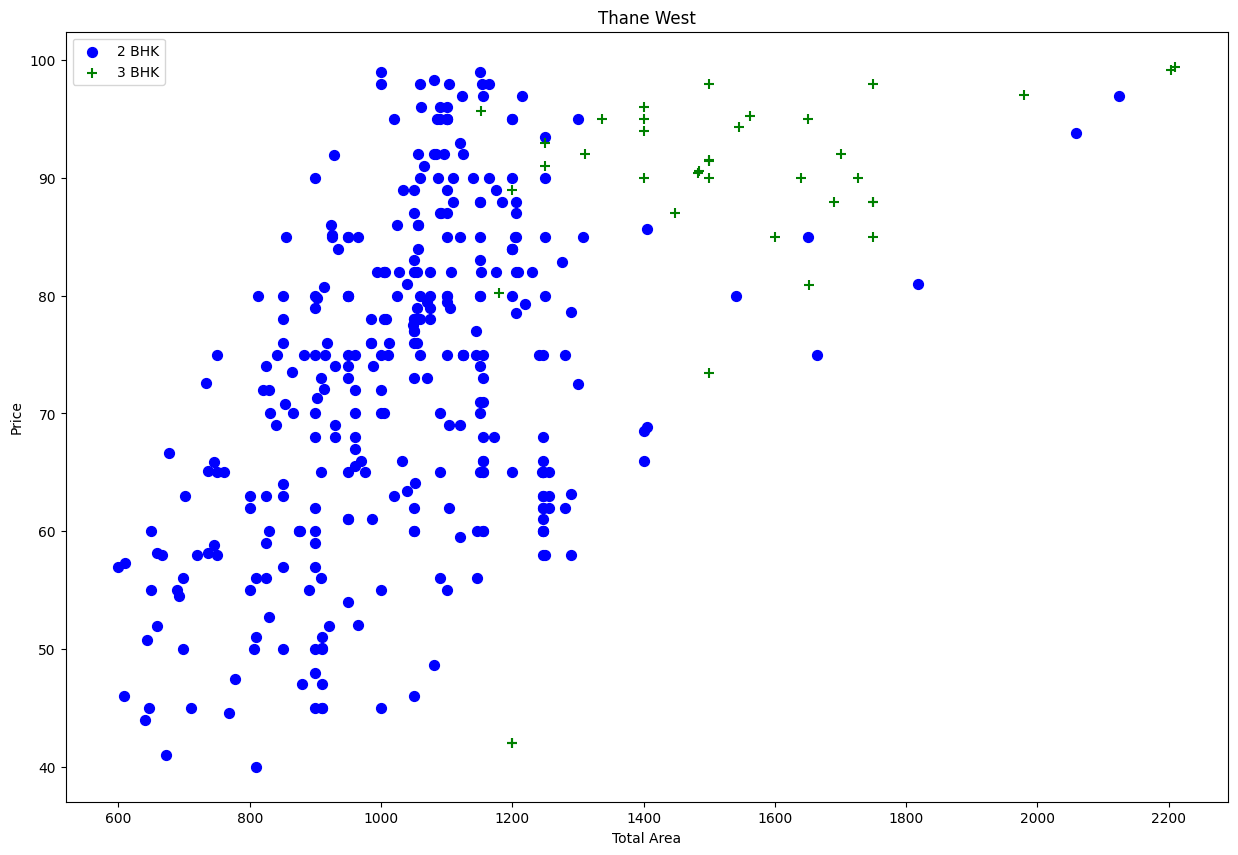

In [423]:
# checking area vs price for 2 and 3 BHK apartments
import matplotlib.pyplot as plt
bhk2 = new_dataset[(new_dataset['region'] == 'Panvel') & (new_dataset['bhk'] == 2)]
bhk3 = new_dataset[(new_dataset['region'] == 'Panvel') & (new_dataset['bhk'] == 3)]
plt.figure(figsize=(15,10))
plt.scatter(bhk2.area, bhk2.price, color='blue', label='2 BHK', s=50)
plt.scatter(bhk3.area, bhk3.price, color='green', label='3 BHK', s=50, marker='+')
plt.xlabel("Total Area")
plt.ylabel("Price")
plt.title('Thane West')
plt.legend()


In [424]:
# we're going to remove those BHK apartments whose price_per_sqft is less than mean price_per_sqft of the lower BHK apartments

exclude_indices = np.array([])
for location, location_df in new_dataset.groupby('region'):
    bhk_stats = {}
    for bhk, bhk_df in new_dataset.groupby('bhk'):
        bhk_stats[bhk] = {
            'mean' : np.mean(bhk_df.price_per_sqft),
            'std' : np.std(bhk_df.price_per_sqft),
            'count' : bhk_df.shape[0]
        }
    for bhk, bhk_df in new_dataset.groupby('bhk'):
        stats = bhk_stats.get(bhk-1)
        if stats and stats['count']>5:
            exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
new_dataset = new_dataset.drop(exclude_indices, axis='index') 
new_dataset.shape           

(19214, 5)

In [425]:
# dropping the price_per_sqft column
new_dataset = new_dataset.drop(columns = ['price_per_sqft'])
new_dataset.head()

,bhk,area,price,region
2,1,803,2.25,Agripada
4,1,684,1.70,Agripada
5,1,545,1.60,Agripada
25,4,3100,20.00,Agripada
29,1,800,2.60,Agripada


One Hot Encoding for Region column

In [426]:
dataset_encoded = pd.get_dummies(new_dataset, columns=['region'])
# Convert only the one-hot encoded columns to integers
# Automatically detects boolean columns and converts them to int
for col in dataset_encoded.columns:
    if dataset_encoded[col].dtype == 'bool':
        dataset_encoded[col] = dataset_encoded[col].astype(int)

print(dataset_encoded.head())

    bhk  area  price  region_Agripada  region_Airoli  region_Ambarnath  \
2     1   803   2.25                1              0                 0   
4     1   684   1.70                1              0                 0   
5     1   545   1.60                1              0                 0   
25    4  3100  20.00                1              0                 0   
29    1   800   2.60                1              0                 0   

    region_Ambernath East  region_Ambernath West  region_Ambivali  \
2                       0                      0                0   
4                       0                      0                0   
5                       0                      0                0   
25                      0                      0                0   
29                      0                      0                0   

    region_Andheri East  ...  region_Vikhroli  region_Vikroli East  \
2                     0  ...                0                    0   


Splitting Independent and Dependent Variables

In [427]:
# X contains all independent variables other than price
X = dataset_encoded.drop(columns=['price'], axis=1)
X.head(10)

,bhk,area,region_Agripada,region_Airoli,region_Ambarnath,region_Ambernath East,region_Ambernath West,region_Ambivali,region_Andheri East,region_Andheri West,...,region_Vikhroli,region_Vikroli East,region_Ville Parle East,region_Ville Parle West,region_Virar,region_Virar East,region_Virar West,region_Wadala,region_Worli,region_kasaradavali thane west
2,1,803,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,684,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,545,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,4,3100,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,1,800,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,1,1015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,1,900,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,1,515,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,1,660,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,3,1350,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [428]:
# y contains a dependent variable price
y = dataset_encoded.price
y.head()

2      2.25
4      1.70
5      1.60
25    20.00
29     2.60
Name: price, dtype: float64

Model Building

In [429]:
# splitting the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [430]:
# Comparing different model's performance using metrics
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
lrmodel = LinearRegression()
lrmodel.fit(X_train, y_train) # training the model
lr_y_pred = lrmodel.predict(X_test)
print("Mean Absolute Error of Linear Regression:", mean_absolute_error(y_test, lr_y_pred))


# Ridge
from sklearn.linear_model import Ridge
ridgemodel = Ridge()
ridgemodel.fit(X_train, y_train) # training the model
ridge_y_pred = ridgemodel.predict(X_test)
print("Mean Absolute Error of Ridge:", mean_absolute_error(y_test, ridge_y_pred))


# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
dtmodel = DecisionTreeRegressor(random_state=42)
dtmodel.fit(X_train, y_train)
dt_y_pred = dtmodel.predict(X_test)
print("Mean Absolute Error of Decision Tree Regressor:", mean_absolute_error(y_test, dt_y_pred))


# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(random_state=42)
rfmodel.fit(X_train, y_train)
rf_accuracy = rfmodel.score(X_test, y_test)
rf_y_pred = rfmodel.predict(X_test)
print("Accuracy of Random Forest Regressor:", rf_accuracy)
print("Mean Absolute Error of Random Forest Regressor:", mean_absolute_error(y_test, rf_y_pred))

# XGBRegressor
from xgboost import XGBRegressor
xgbmodel = XGBRegressor(random_state=42)
xgbmodel.fit(X_train, y_train)
xgb_y_pred = xgbmodel.predict(X_test)
print("Mean Absolute Error of XGB Regressor:", mean_absolute_error(y_test, xgb_y_pred))

Mean Absolute Error of Linear Regression: 8.608554017337527
Mean Absolute Error of Ridge: 8.627769742681227
Mean Absolute Error of Decision Tree Regressor: 5.704580206882984
Accuracy of Random Forest Regressor: 0.8805130431250845
Mean Absolute Error of Random Forest Regressor: 5.555588719708198
Mean Absolute Error of XGB Regressor: 5.993349489529649


In [431]:
# K-Fold cross-validation
from sklearn.model_selection import ShuffleSplit, cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(rfmodel, X, y, cv=cv)

array([0.89389305, 0.89325933, 0.87513   , 0.89505845, 0.88778222])

In [432]:
def predict_price(region, bhk, area):
    loc_index = np.where(X.columns==f"region_{region}")[0][0]
    x = np.zeros(len(X.columns))
    x[0] = bhk
    x[1] = area
    if loc_index >= 0:
        x[loc_index] = 1
    return rfmodel.predict([x])[0]

Model Testing

In [433]:
predict_price('Agripada', 1, 1000)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


12.093799999999998

In [434]:
predict_price('Agripada', 1, 500)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


2.1217383333333326

In [435]:
predict_price('Panvel', 1, 1000)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


59.357733333333336

In [436]:
predict_price('Panvel', 2, 1000)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


81.85622857142859